<a href="https://colab.research.google.com/github/Ashishd133/Unet-using-Pytorch/blob/main/Unet_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.transforms.functional
from torch import nn

In [ ]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # First 3x3 convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second 3x3 convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)

In [ ]:
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)


In [ ]:
class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

In [ ]:
class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        return x


In [ ]:
class UNet(nn.Module):
    def __init__(self, out_channels: int):

        super().__init__()
        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from 64.
        down_conv_sizes = [(3, 64), (64, 128), (128, 256), (256, 512)]
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in down_conv_sizes])

        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(512, 1024)

        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        upsample_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]

        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in upsample_sizes])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        up_conv_sizes = [(1024, 512), (512, 256), (256, 128), (128, 64)]
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in up_conv_sizes])

        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])

        # Final 1x1 convolution layer to produce the output
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two 3x3 convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two 3x3 convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two 3x3 convolutional layers
            x = self.up_conv[i](x)

        # Final 1x1 convolution layer
        out = self.final_conv(x)

        return out

In [ ]:
import testing

Epoch 0/59
----------
LR 0.0001


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train: bce: 0.680338, dice: 0.990583, loss: 0.835461
val: bce: 0.673479, dice: 0.990939, loss: 0.832209
saving best model
0m 4s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.670195, dice: 0.990549, loss: 0.830372
val: bce: 0.663893, dice: 0.990918, loss: 0.827406
saving best model
0m 3s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.658990, dice: 0.990527, loss: 0.824758
val: bce: 0.648695, dice: 0.990901, loss: 0.819798
saving best model
0m 3s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.638963, dice: 0.990508, loss: 0.814735
val: bce: 0.617958, dice: 0.990883, loss: 0.804420
saving best model
0m 3s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.596076, dice: 0.990500, loss: 0.793288
val: bce: 0.544141, dice: 0.990949, loss: 0.767545
saving best model
0m 3s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.476576, dice: 0.990751, loss: 0.733664
val: bce: 0.293068, dice: 0.992123, loss: 0.642596
saving best model
0m 3s
Epoch 6/59
----------
LR 0.0001
train: bce: 0.156246, dice: 0.994318, lo

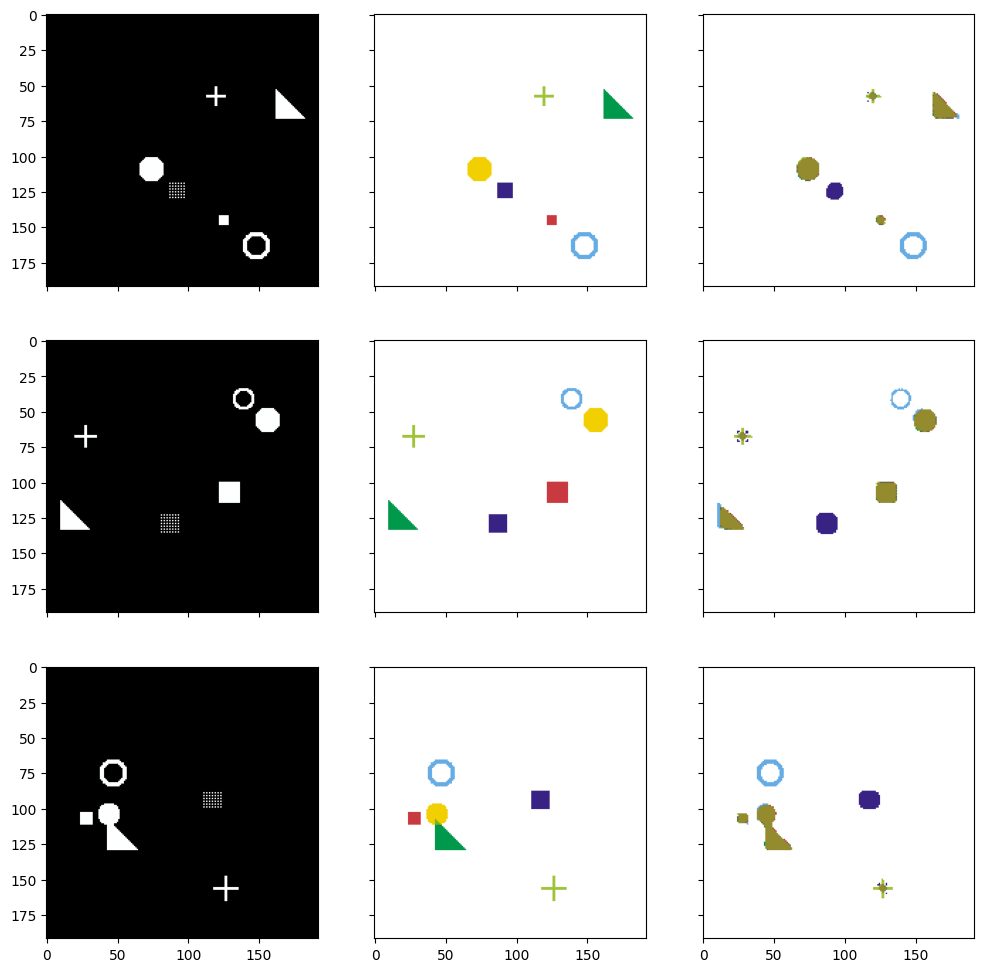

In [ ]:
testing.run(UNet)